C:\Users\GlebP\AppData\Local\Temp\ipykernel_12108\1800362062.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('BrBG')
MovieWriter ffmpeg unavailable; using Pillow instead.


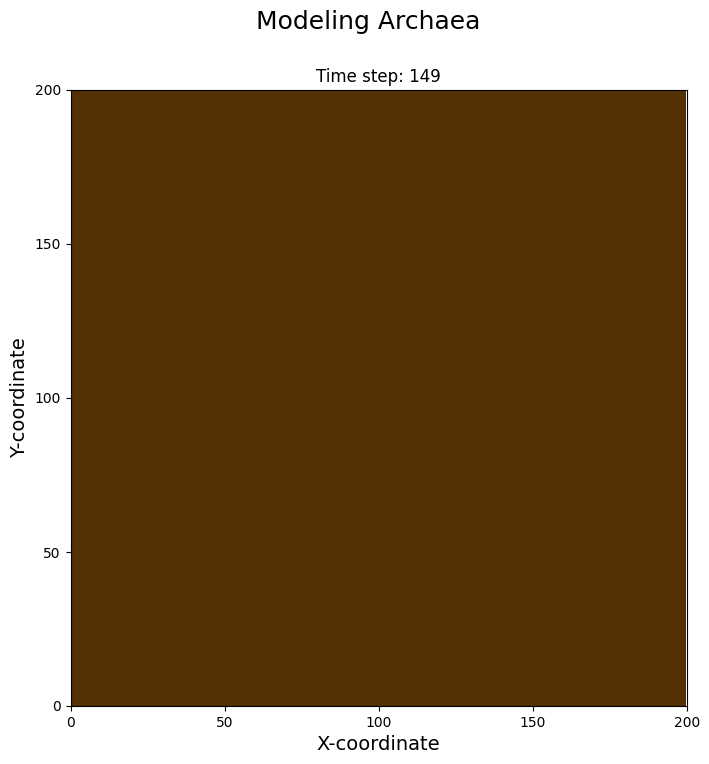

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

# Parameters
grid_size = 200  # Size of the grid
initial_archea_count = 4  # Initial number of archaea
oil_density = 0.5  # Oil density in the grid (0-1)
methane_replacement_probability = 0.75
water_replacement_probability = 0.25
archea_movement_probability = 0.5  # Probability of archaea movement
archea_reproduction_probability = 0.03  # Probability of archaea reproduction
oil_consumption_rate = 0.5  # Rate of oil consumption by archaea
consumption_radius = 1  # Radius of oil consumption around archaea
starvation_frames = 20  # Number of frames without oil after which archaea die

# Create grid
grid = np.random.rand(grid_size, grid_size)
grid[grid < oil_density] = 1  # Oil
grid[np.logical_and(grid >= oil_density, grid < oil_density + methane_replacement_probability)] = 2  # Methane
grid[grid >= oil_density + methane_replacement_probability] = 3  # Water

# Create initial population of archaea
archea_positions = np.array(
    [(random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)) for _ in range(initial_archea_count)]
)

# Create figure and axes for animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Create color palette
cmap = plt.cm.get_cmap('BrBG')
cmap.set_bad(color='saddlebrown')
cmap.set_under('black')  # Oil
cmap.set_over('blue')  # Methane
cmap.set_bad('green')  # Water

# Display grid with oil, methane, and water
oil_plot = ax.imshow(grid == 1, cmap=cmap, interpolation='nearest')
methane_plot = ax.imshow(grid == 2, cmap=cmap, interpolation='nearest')
water_plot = ax.imshow(grid == 3, cmap=cmap, interpolation='nearest')
archea_plot, = ax.plot(archea_positions[:, 0], archea_positions[:, 1], 'ro', markersize=3)  # Smaller archaea marker

# Add starvation counters for each archaea
starvation_counters = np.zeros(len(archea_positions), dtype=int)

# Function to update animation frame
def animate(frame):
    global archea_positions, grid, starvation_counters
    # Move archaea
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < archea_movement_probability:
            # Choose random direction
            dx = random.randint(-1, 1)
            dy = random.randint(-1, 1)
            new_x = (x + dx) % grid_size
            new_y = (y + dy) % grid_size
            archea_positions[i] = (new_x, new_y)

    # Reproduction of archaea
    new_archea_positions = []
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < archea_reproduction_probability:
            # Choose random direction for new archaea
            direction = random.randint(0, 3)
            if direction == 0:
                new_pos = ((x + 1) % grid_size, y)
            elif direction == 1:
                new_pos = ((x - 1) % grid_size, y)
            elif direction == 2:
                new_pos = (x, (y + 1) % grid_size)
            else:
                new_pos = (x, (y - 1) % grid_size)

            # Check if the new position is free (not occupied by oil or other archaea)
            if grid[new_pos[1], new_pos[0]] == 0 and new_pos not in new_archea_positions:
                new_archea_positions.append(new_pos)

    new_archea_positions = np.array(new_archea_positions)

    if new_archea_positions.size > 0:
        archea_positions = np.vstack((archea_positions, new_archea_positions))
        starvation_counters = np.append(starvation_counters, np.zeros(len(new_archea_positions), dtype=int))

    # Oil consumption around archaea
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        found_oil = False
        for dx in range(-consumption_radius, consumption_radius + 1):
            for dy in range(-consumption_radius, consumption_radius + 1):
                if abs(dx) + abs(dy) <= consumption_radius:  # Manhattan distance
                    nx = (x + dx) % grid_size
                    ny = (y + dy) % grid_size
                    if grid[ny, nx] == 1:
                        grid[ny, nx] = 0  # Consume oil
                        found_oil = True
                        break
            if found_oil:
                break

        if found_oil:
            starvation_counters[i] = 0
        else:
            starvation_counters[i] += 1

    # Remove starving archaea
    dead_archea_indices = np.where(starvation_counters >= starvation_frames)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)

    # Update images
    oil_plot.set_data(grid == 1)
    methane_plot.set_data(grid == 2)
    water_plot.set_data(grid == 3)
    archea_plot.set_data(archea_positions[:, 0], archea_positions[:, 1])
    ax.set_title(f"Time step: {frame}")
    ax.set_xlabel("X-coordinate", fontsize=14)
    ax.set_ylabel("Y-coordinate", fontsize=14)
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size + 1, 50))
    ax.set_yticks(np.arange(0, grid_size + 1, 50))
    fig.suptitle("Modeling Archaea", fontsize=18)
    ax.set_aspect('equal')
    return oil_plot, methane_plot, water_plot, archea_plot

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=150, interval=300, blit=True)
ani.save('oil.gif')
plt.show()